In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Importing data

We are first loading the train and test data.

In [2]:
train_file_path = 'lab2_train.csv'
test_file_path = 'lab2_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

### What properties of the data do you think are important for your pipeline design?

By visualizing the pairs of likes between users, we can see that users with higher IDs (potentially new users in the system) are not interacting a lot with users with lower IDs (older users in the system). This could mean the system did not recommend users registered earlier to new registered users, maybe due to the inactivity of older users.

The idea that higher IDs suggest more recent users in the system is also supported by the sparsity of the data towards higher IDs. The users joined recently, so they did not have many interactions with the other users in the system.

Regarding the recommender system pipeline, the sparsity of data means that for some users that have only a few interactions, the system might not provide many recommendations and these might not be very accurate either.

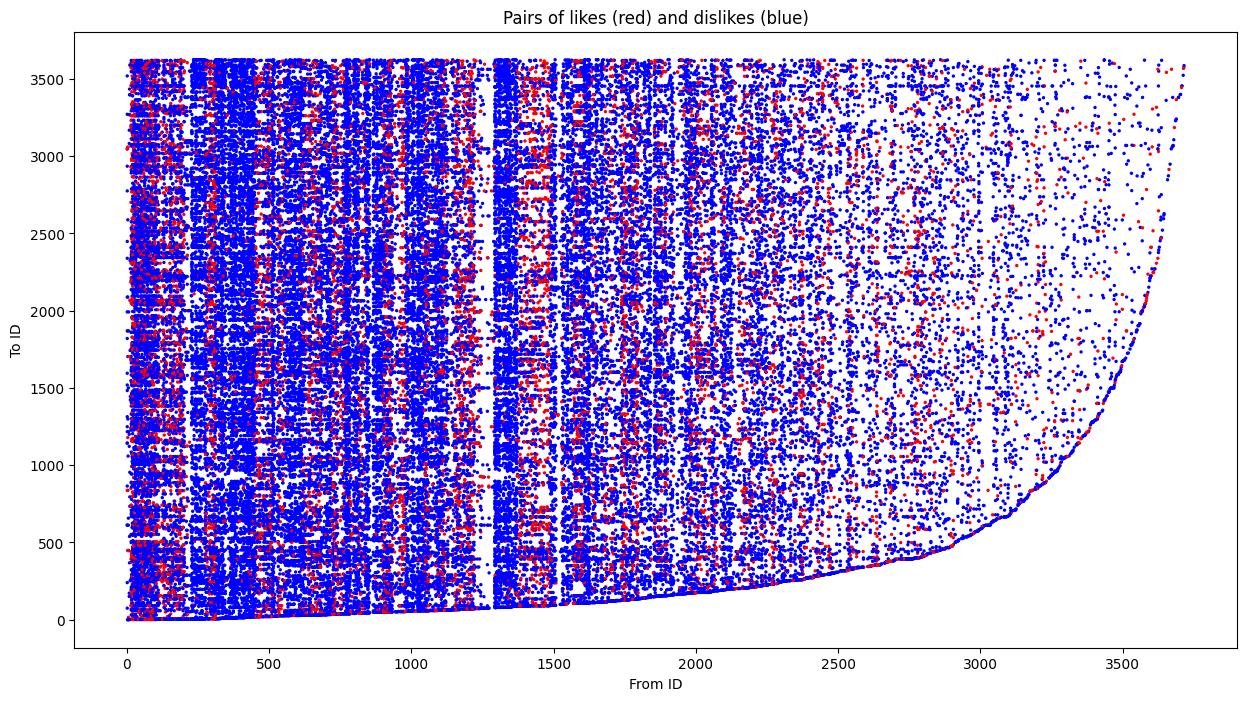

In [3]:
is_like = train_data['is_like'].to_numpy()

colors = ['red' if v else 'blue' for v in is_like]
# 'red' -> 'Like', 'blue' -> 'Dislike'

plt.figure(figsize=(15, 8))
plt.scatter(x=train_data['user_from_id'], y=train_data['user_to_id'], c=colors, s=2)
plt.xlabel('From ID')
plt.ylabel('To ID')
plt.title('Pairs of likes (red) and dislikes (blue)')

plt.show()

### 2. Do you see different types of people (in terms of both which id pairs are present and what they like/don’t like)?


From the plot below, we can draw some conclusions regarding the types of people on Breeze:
- The inactive users: at around id 1200, there was an influx of users that did not send (m)any match requests. 
(We can assume that they are either bots, or users that uninstalled/didn't use the app)
- The "unlucky" users: from the plot, there are blue stripes occurring from time to time. That represents the users that
did not find a match, even though they liked most users they came across.
- The "angry" users: there are also gray stripes, representing users that did not like users they ran into, and they also
weren't liked back.

When talking about more recent users, the data is too sparse to draw an accurate conclusion.

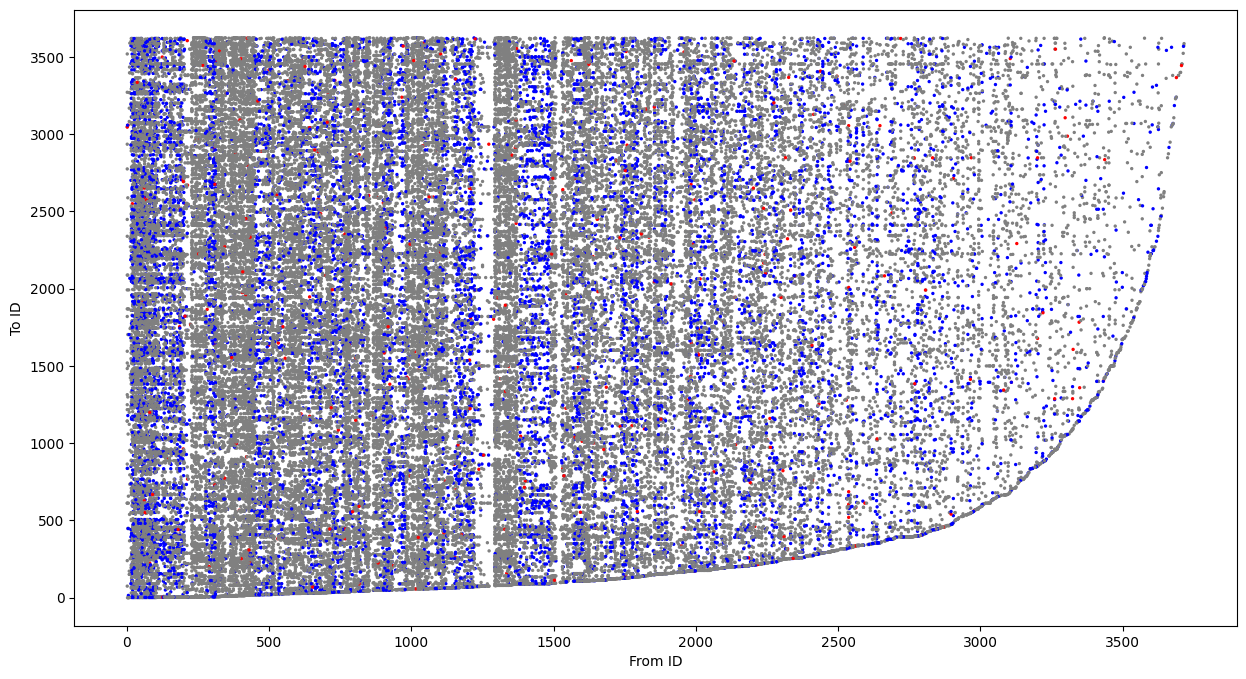

In [4]:
is_like = train_data['is_like'].to_numpy()
is_match = train_data['is_match'].to_numpy()

colors = []
for i in range(len(is_like)):
    if is_match[i] == 1:
        colors.append('red')
    elif is_like[i] == 1:
        colors.append('blue')
    else:
        colors.append('gray')

plt.figure(figsize=(15, 8))
plt.scatter(x=train_data['user_from_id'], y=train_data['user_to_id'], c=colors, s=2)

plt.xlabel('From ID')
plt.ylabel('To ID')

plt.show()

### Non-negative matrix factorization

The code cell below contains the Weblab submission.

In [5]:
def reconstruction_error(X: pd.DataFrame, W: pd.DataFrame, H: pd.DataFrame):
    """
    Compute the reconstruction error E = || V - WH || ^ 2. NaN values (missing values) in X do not contribute towards the error.
    """
    return np.nansum((X - W @ H) ** 2)
    

def nmf(X: pd.DataFrame, n_components: int, max_iter: int=1000, tol: float=1e-4, debug_steps: bool=False):
  """
  Decomposes the original sparse matrix X into two matrices W and H. 
  """
  # Initialize W and H with random non-negative values
  W = np.random.rand(X.shape[0], n_components)
  H = np.random.rand(n_components, X.shape[1])

  curr_iter = 0
  prev_error = reconstruction_error(X, W, H)
  epsilon = 1e-9   
  
  # NaN values are treated as 0 in the multiplication
  X_without_nan = X.fillna(0)
  
  while curr_iter < max_iter:
    H = H * (W.T @ X_without_nan) / ((W.T @ W @ H) + epsilon)
    W = W * (X_without_nan @ H.T) / ((W @ H @ H.T) + epsilon)
    
    # NaN values have no loss contribution
    curr_error = reconstruction_error(X, W, H)
    if debug_steps:
        print(f'iteration {curr_iter}, error {curr_error}')
    
    if abs(curr_error - prev_error) < tol:
      break
        
    prev_error = curr_error
    curr_iter += 1

  return W, H

#### Pre-processing - Dealing with duplicates

We use majority vote to deal with duplicate interactions between users (e.g. user X first liked user Y, then user X disliked user Y). If between 2 users there are fewer likes than dislikes, then we count it as a dislike, otherwise a like. If the data had timestamps, we could have simply taken the most recent interaction between the 2 users.

In [6]:
def solve_duplicates(data: pd.DataFrame):
    # for each user IDs pair count the number of likes and total interactions
    grouped_data = data.groupby(['user_from_id', 'user_to_id']).agg({'is_like': ['sum', 'count']}).reset_index()
    
    unique_data = []
    
    for index, row in grouped_data.iterrows():
        # for each pair get the user ids, like and dislike counts
        a = row['user_from_id'].iloc[0]
        b = row['user_to_id'].iloc[0]
        like_count = int(row['is_like']['sum'])
        dislike_count = int(row['is_like']['count']) - like_count    
        
        if like_count < dislike_count:
            row = pd.Series({'user_from_id':a, 'user_to_id':b, 'is_like':0})
        else:
            row = pd.Series({'user_from_id':a, 'user_to_id':b, 'is_like':1})
            
        unique_data.append(row)   
    
    return pd.DataFrame(unique_data)
    
    
unique_train_data = solve_duplicates(train_data)
print(f'Removed {train_data.shape[0] - unique_train_data.shape[0]} duplicates.')

Removed 4251 duplicates.


### Pre-processing - Creating the utility matrix
Next, we use the `unique_train_data` to create an NxN `utility_matrix`, where N is the maximum user ID and initialize it with NaN values. Then we set the elements corresponding to likes/dislikes with numerical values 1 or 0. This means we don't need normalization, since we are only dealing with discrete values 0 and 1, and they are included in the interval [0, 1] used for the randomization of W and H.



In [7]:
def build_utility_matrix(data: pd.DataFrame, max_user_id: int = 0):
    # the size of the matrix depends on the largest user ID
    if max_user_id == 0:
        max_user_id = max(data['user_from_id'].max(), data['user_to_id'].max())
    
    # create an empty utility matrix with NaN values
    utility_mat = np.full((max_user_id + 1, max_user_id + 1), np.nan)
    
    # set the corresponding likes/dislikes
    for index, row in data.iterrows():
        a = row['user_from_id']
        b = row['user_to_id']
        is_like = row['is_like']
                
        utility_mat[a, b] = is_like
    
    return pd.DataFrame(utility_mat)
    
utility_matrix = build_utility_matrix(unique_train_data)
print(utility_matrix.shape)

(3717, 3717)


#### Fine tuning

In order to choose the hyperparameter k, the number of features used in NMF, we use 4-fold cross-validation. One quarter of the set is the validation set and the rest is used for training. After computing NMF, we evaluate the reconstruction errors by comparing the utility matrices of both the train and the validation set to the reconstructed matrix ` W * H `. We average these errors for all 4 folds to obtain the final train score and cross-validation score. To reduce the runtime, we set an upper bound of 100 on the iterations of NMF, which didn't affect the results significantly.

In [8]:
def cross_validate(data: pd.DataFrame, max_user_id: int, n_components: int, num_folds: int):
    # shuffle row indices in the data set
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    fold_size = len(data) // num_folds
    train_scores = []
    cv_scores = []
    
    for i in range(num_folds):
        # calculate the indices of the current fold
        fold_start = i * fold_size
        fold_end = (i + 1) * fold_size
        if i == num_folds - 1:
            fold_end = len(data)
        
        # select the current train and validation sets with random indices
        curr_validation_data = data.iloc[indices[fold_start:fold_end]]
        curr_train_data = pd.concat([data.iloc[indices[:fold_start]], data.iloc[indices[fold_end:]]])
        
        # build the utility matrices for both the train and the validation sets
        train_utility_matrix = build_utility_matrix(curr_train_data, max_user_id=max_user_id)
        validation_utility_matrix = build_utility_matrix(curr_validation_data, max_user_id=max_user_id)
        
        # run NMF on the train set, set max iterations to 100 to lower the runtime
        W, H = nmf(train_utility_matrix, n_components=n_components, max_iter=100)
        
        # evaluate the reconstruction error on both the train and the validation set
        train_reconstruction_error = reconstruction_error(train_utility_matrix, W, H)
        validation_reconstruction_error = reconstruction_error(validation_utility_matrix, W, H)       
        train_scores.append(train_reconstruction_error)
        cv_scores.append(validation_reconstruction_error)
    
    # return the mean scores for all folds
    return np.array(train_scores).mean(), np.array(cv_scores).mean()

#### Fine tuning - Choosing k

After running 4-fold cross-validation for values of k between `[0, 400]` with a step of 50, we obtained the plot below. We can see that the optimal value for k is somewhere between 250 and 300, since this is where the validation score drops below the train score.

![cross-validation-plot](cross_validation_0_400.png)

Then, we ran 4-fold cross-validation again for values of k between `[250, 290]` with a step of 10.

![cross-validation-plot2](cross_validation_250_290.png)

Finally, we ran 4-fold cross-validation for values of k between `[270, 279]` with a step of 1. From the plot below, we can see that the optimal value for k is `273`.

![cross-validation-plot3](cross_validation_270_279.png)

The code cell below contains the code we used for doing cross-validation and plotting the results.

In [ ]:
overall_max_user_id = max(train_data['user_from_id'].max(), train_data['user_to_id'].max())

components = []
t_scores = []
v_scores = []

for i in tqdm(range(0, 401, 50)):
    train_score, cv_score = cross_validate(unique_train_data, overall_max_user_id, n_components=i, num_folds=4) 
    components.append(i)
    t_scores.append(train_score)
    v_scores.append(cv_score)

plt.plot(components, t_scores, color='blue', label='Train Score')
plt.plot(components, v_scores, color='orange', label='Validation Score')
plt.xlabel('Number of Features (k)')
plt.xticks(components)
plt.ylabel('Cross-Validation Score') 
plt.title('Cross-Validation Scores for NMF')
plt.legend()
plt.show()

### Run NMF
Now let's see what the reconstruction error is for ` k = 273` with default values for the error tolerance (`1e-4`) and the max_iterations (`1000`). We chose to use these specific values as, from our tests, they seem like a reasonable trade-off between high computational costs and converging to an accurate solution. A higher error tolerance or a lower iterations bound could mean less accurate results (underfitting), while a lower tolerance or a higher iterations bound might cause overfitting.

In [10]:
W, H = nmf(utility_matrix, 273, debug_steps=True)

print(reconstruction_error(utility_matrix, W, H))

iteration 0, error 12006.73040548255
iteration 1, error 11861.437566003875
iteration 2, error 11667.832450350268
iteration 3, error 11004.485063962667
iteration 4, error 9065.320611318222
iteration 5, error 7359.157811929413
iteration 6, error 6396.621683425437
iteration 7, error 5834.819580318194
iteration 8, error 5470.939774578636
iteration 9, error 5220.126778406805
iteration 10, error 5039.974819666217
iteration 11, error 4908.4378660340835
iteration 12, error 4808.143359070177
iteration 13, error 4729.78034706417
iteration 14, error 4666.973099164598
iteration 15, error 4614.427459487649
iteration 16, error 4569.586996884763
iteration 17, error 4531.88141206625
iteration 18, error 4500.240135562609
iteration 19, error 4473.055652252752
iteration 20, error 4449.487825717275
iteration 21, error 4429.081461220535
iteration 22, error 4411.083825816775
iteration 23, error 4394.3304479859335
iteration 24, error 4378.561717011229
iteration 25, error 4364.0743697968155
iteration 26, erro

### Pick a recommendation threshold

The code cell below plots the reconstruction error for thresholds between `[0, 2]`. As we can see the minimum reconstruction error is attained for `0.14`, so we pick this value for the recommendation threshold.

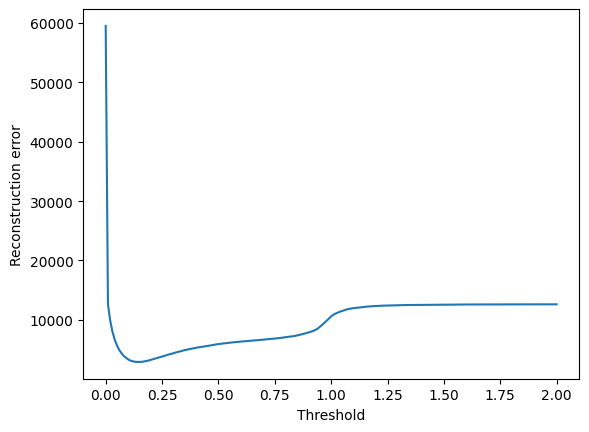

Threshold: 0.14
Reconstruction error: 2904.0


In [13]:
predicted = W @ H

x_values = np.arange(0, 2.01, 0.01)
y_values = []
for x in x_values:
    predicted_vals = np.where(predicted >= x, 1, 0)
    y_values.append(np.nansum((utility_matrix - predicted_vals) ** 2))

plt.plot(x_values, y_values)
plt.xlabel('Threshold')
plt.ylabel('Reconstruction error')
plt.show()

min_index = np.argmin(y_values)
threshold = x_values[min_index]
predicted_vals = np.where(predicted >= threshold, 1, 0)
print(f'Threshold: {threshold}')
print(f'Reconstruction error: {np.nansum((utility_matrix - predicted_vals) ** 2)}')

# Minhashing 


#### Weblab method

In [31]:
import numpy as np
import sys
from library import HashFunction


def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """

    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)
    for ix,r in enumerate(sorted_space):
        for c in range(result.shape[1]):
            if r in ids[c]:
                for i, hf in enumerate(hashes):
                    result[i][c] = min(result[i][c], hf.hashf(ix, len(sorted_space)))

    return result

In order to generate the signature matrix in our case, we only need to consider the "likes" each user has sent.


In [ ]:
likes = train_data[train_data['is_like']]

Now, we start by implementing a basic recommender, which only returns recommendations if the users' signature matrix columns are the same.

In [ ]:
def minhashing_recommender(hash_list=[[1, 1]], user_user=True):
    """
    the easiest min-hashing recommender
    :param hash_list: The list of hash functions of arbitrary length
    :param user_user: Whether to do user-user or item-item based recommendation
    :return: a dictionary containing recommendations for each user
    """
    # transform list of parameters into hashFunctions
    hash_funcs = []
    for hash_params in hash_list:
        hash_funcs.append(HashFunction(hash_params[0], hash_params[1]))
    
    
    # create sets for the min-hashing matrix based on the is_like column
    preference_sets = {}
    if user_user:
        #user-user : we store preferences of users that sent requests
        for from_id, to_id in zip(likes['user_from_id'], likes['user_to_id']):
            if from_id not in preference_sets:
                preference_sets[from_id] = set()
            preference_sets[from_id].add(to_id)
    else:
        #item-item : we store preferences of users that received requests
        for from_id, to_id in zip(likes['user_from_id'], likes['user_to_id']):
            if to_id not in preference_sets:
                preference_sets[to_id] = set()
            preference_sets[to_id].add(from_id)

    ids = list(preference_sets.values())
    sign_mat = compute_signature(hashes=hash_funcs, ids=ids)

    #compile recommendations - SIMPLE WAY - returning pairs with equal hash signatures
    
    
    link = dict(enumerate(list(preference_sets.keys())))
    recommendations = {}

    #
    for i in range(sign_mat.shape[1]):
        for j in range(i + 1, sign_mat.shape[1]):
            if np.array_equal(sign_mat[:, i], sign_mat[:, j]):
                if link[i] not in recommendations:
                    recommendations[link[i]] = []
                if link[j] not in recommendations:
                    recommendations[link[j]] = []
                recommendations[link[i]].append(link[j])
                recommendations[link[i]].sort()
                recommendations[link[j]].append(link[i])
                recommendations[link[j]].sort()
    return recommendations

Now that we have a way of recommending accounts to people, we can play around with values;

The code below tests:
  -  3 hash functions
  -  3 _other_ hash functions
  -  one hash function
  -  item-item recommendation
  - user-user recommendation ( same hash functions as item-item)

In [ ]:
recommendations = minhashing_recommender([[12, 37], [7, 35],[9,45]])
#print(recommendations)
temp_hash1 = list(recommendations.keys())
temp_hash1.sort()

#print(temp)
#print(recommendations[4])
#print(users_likes[4],users_likes[2])


print("3 hash values:")
print("2: ",recommendations[2])
print("14: ",recommendations[14])
print("18: ",recommendations[18])
print("20: ",recommendations[20])
#print(users_likes[3674],users_likes[2])




recommendations = minhashing_recommender([[13, 23], [7, 19],[31,5]])
temp_hash2 = list(recommendations.keys())
temp_hash2.sort()
# there are different recommendations for the dataset: some ids have new ones, while some don't have any anymore.
# to see that, uncomment the line below, which prints out items in the first recommendation list but not in the second:
# print(np.setdiff1d(temp_hash1, temp_hash2))


print("3 other hash values:")
print("2: ",recommendations[2])
print("14: ",recommendations[14])
print("18: ",recommendations[18])
print("20: ",recommendations[20])



recommendations = minhashing_recommender([[13, 23]])

print("one hash value:")
print("2: ",recommendations[2])
print("14: ",recommendations[14])
print("18: ",recommendations[18])
print("20: ",recommendations[20])




recommendations_user_user = minhashing_recommender([[13, 23], [7, 19],[31,5]], True)
recommendations_item_item = minhashing_recommender([[13, 23], [7, 19],[31,5]], False)

print(recommendations_user_user[20], recommendations_item_item[20])

From the code above (and the output), we can conclude multiple things:
1. The number and parameters of the hash functions actively impact the recommendations:
   -  more hash values are more restrictive with recommendations, as columns still need to be equal.
   -  different hash parameters can lead to different recommendations because of events like collisions.
2. User-user and item-item recommendation differ quite heavily:
   -  when using user-user recommendations, we only take into account the likes that an account has sent for the recommendation, while in item-item, we take into account likes that an user has received.


While the code above works at providing recommendations, it cannot give them to every account, as it relies on exact matches. In that sense, we can prevent that by using the Jaccard index and returning an amount K of neighbors which match the user in some sense (i.e. with the highest index/smallest distance).

This can be further improved by setting a threshold for the index such that only proper matches are returned, and there is no random recommendation flowing out.

In [ ]:
def compute_signature_matrix(hash_list=[[1, 1]], user_user=True):
    """
    this function computes the signature matrix from the given data.
    :param hash_list: The list of hash functions of arbitrary length
    :param user_user: Whether to do user-user or item-item based recommendation
    :return: the signature matrix
    """
    # transform list of parameters into hashFunctions
    hash_funcs = []
    for hash_params in hash_list:
        hash_funcs.append(HashFunction(hash_params[0], hash_params[1]))
    
    
    # create sets for the min-hashing matrix based on the is_like column
    preference_sets = {}
    if user_user:
        #user-user : we store preferences of users that sent requests
        for from_id, to_id in zip(likes['user_from_id'], likes['user_to_id']):
            if from_id not in preference_sets:
                preference_sets[from_id] = set()
            preference_sets[from_id].add(to_id)
    else:
        #item-item : we store preferences of users that received requests
        for from_id, to_id in zip(likes['user_from_id'], likes['user_to_id']):
            if to_id not in preference_sets:
                preference_sets[to_id] = set()
            preference_sets[to_id].add(from_id)

    ids = list(preference_sets.values())
    sign_mat = compute_signature(hashes=hash_funcs, ids=ids)
    return sign_mat

In [ ]:
def calculate_jaccard_distance(sig1, sig2):
    """
    this function computes the Jaccard distance between two signature vectors
    :param sig1: the first signature vector
    :param sig2: the second signature vector
    :return: the Jaccard distance
    """
    intersection = np.intersect1d(sig1,sig2)
    union = np.union1d(sig1,sig2)
    
    if len(intersection) == 0:
        return 1
    else:
        return 1 - len(intersection) / len(union)

def find_nearest_neighbors(signature_matrix, k=5, threshold = 0.8):
    """
    this function computes k nearest neighbors for all users
    :param threshold: threshold for distance calculation
    :param signature_matrix: the signature matrix of the data
    :param k: the number of neighbors to return
    :return: a dictionary with the nearest neighbors of each user ID, based on jaccard distance and 
    excluding already-liked users.
    """
    nearest_neighbors = {}

    for i in range(signature_matrix.shape[1]):
        distances = []

        for j in range(signature_matrix.shape[1]):
            if i == j:
                continue

            distance = calculate_jaccard_distance(signature_matrix[:,i], signature_matrix[:,j])
            distances.append((distance, j))

        distances.sort(key=lambda x: x[0])
        nei = 0
        neighbors = []
        while nei < k:
            if (distances[nei][1] not in likes[likes["user_from_id"]== i]["user_to_id"] 
                    and distances[nei][0]<threshold):
                neighbors.append(distances[nei])
            nei+=1
            if nei > 4*k: break
        nearest_neighbors[i] = neighbors

    return nearest_neighbors



Using the Jaccard distance as a metric and setting a threshold for it, we can match users with people with similar tastes. 

In [ ]:
import pprint
sm = compute_signature_matrix(hash_list=[[3,7],[9,15]])
neighbors = find_nearest_neighbors(sm)
pprint.pprint(neighbors)